In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import os
from glob import glob
from matplotlib.colors import LogNorm

from scipy.optimize import curve_fit

from astropy.table import Table
import astropy.io.fits as fits
from astropy.stats import LombScargle, BoxLeastSquares
import exoplanet as xo
from stuff import FINDflare, EasyE

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

## Explore
After the per-sector basic search (flare+rotation) has been run, make some exploratory plots!

In [90]:
tess_dir = '/Users/james/Desktop/tess/'

sectors = ['sector001', 'sector002', 'sector003', 'sector004', 'sector005', 'sector006']

df1 = pd.read_csv(tess_dir + 'gaiatess1_xmatch_1arsec-result.csv')
df2 = pd.read_csv(tess_dir + 'gaiatess2_xmatch_1arsec-result.csv')
df3 = pd.read_csv(tess_dir + 'gaiatess3_xmatch_1arsec-result.csv')
df4 = pd.read_csv(tess_dir + 'gaiatess4_xmatch_1arsec-result.csv')
df5 = pd.read_csv(tess_dir + 'gaiatess5_xmatch_1arsec-result.csv')
df6 = pd.read_csv(tess_dir + 'gaiatess6_xmatch_1arsec-result.csv')

df = pd.concat([df1, df2, df3, df4, df5, df6], 
               ignore_index=True, sort=False)


In [91]:
rot1 = pd.read_csv('sector001_rot_out.csv')
rot2 = pd.read_csv('sector002_rot_out.csv')
rot3 = pd.read_csv('sector003_rot_out.csv')
rot4 = pd.read_csv('sector004_rot_out.csv')
rot5 = pd.read_csv('sector005_rot_out.csv')
rot6 = pd.read_csv('sector006_rot_out.csv')

rot = pd.concat([rot1, rot2, rot3, rot4, rot5, rot6],
               ignore_index=True, sort=False)

gdata = pd.merge(df, rot, right_on='TIC', left_on='ticid')
print(gdata.shape, rot.shape, df.shape)

(247178, 141) (107837, 11) (87799, 130)


Text(0, 0.5, 'Dec [deg]')

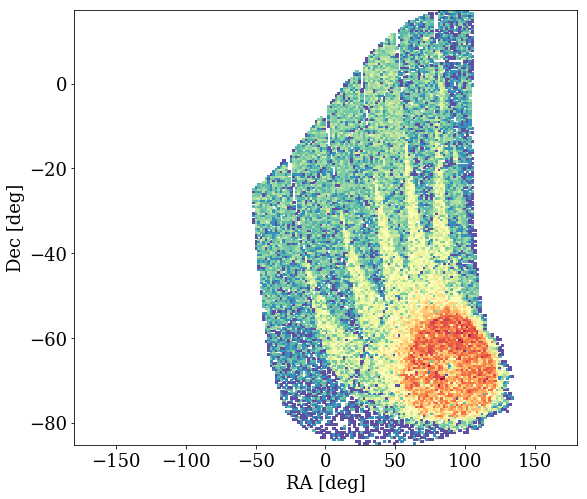

In [92]:

plt.figure(figsize=(9,8))
_ = plt.hist2d(gdata['ra'], gdata['dec'], bins=(200,200), cmap=plt.cm.Spectral_r, norm=LogNorm())
_ = plt.hist2d(gdata['ra']-360, gdata['dec'], bins=(200,200), cmap=plt.cm.Spectral_r, norm=LogNorm())
plt.xlim(-180,180)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')


In [93]:
ok = np.where(np.isfinite(gdata[u'parallax']) & # this is basically the same as the TGAS file...
              (gdata[u'parallax_error'] / gdata[u'parallax'] < 0.1) &
              (gdata[u'modality_flag'] == 1) & 
              (gdata[u'result_flag'] == 1) &
              np.isfinite(gdata[u'bp_rp']) & 
              (gdata[u'phot_bp_mean_flux_error']/gdata[u'phot_bp_mean_flux'] < 0.01) & 
              (gdata[u'phot_rp_mean_flux_error']/gdata[u'phot_rp_mean_flux'] < 0.01) & 
              (gdata[u'phot_g_mean_flux_error']/gdata[u'phot_g_mean_flux'] < 0.01) & 
              (gdata['per'] > 0.1))[0]
#               (gdata['Pamp']/gdata['Pmed'] > 200) & 
#               (gdata['Pamp'] > 0.5))[0]
print(ok.shape)

(231678,)


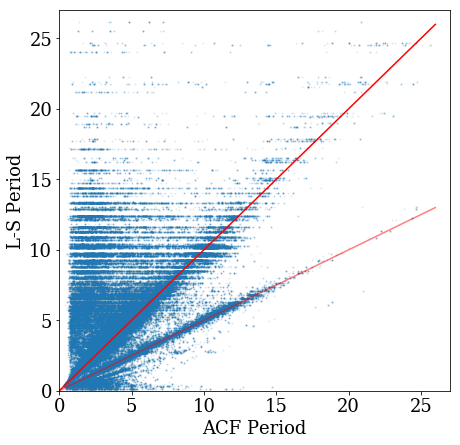

In [94]:
plt.figure(figsize=(7,7))
plt.scatter(gdata['acf_per'].values[ok], gdata['per'].values[ok], alpha=0.1, s=1)

plt.xlabel('ACF Period')
plt.ylabel('L-S Period')
plt.xlim(0,27)
plt.ylim(0,27)

plt.plot([0,26], [0,26], c='r')
plt.plot([0,26], [0,13], c='r', alpha=0.5)

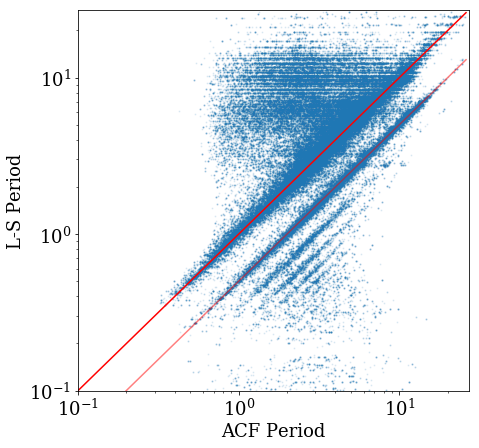

In [95]:
plt.figure(figsize=(7,7))
plt.scatter(gdata['acf_per'].values[ok], gdata['per'].values[ok], alpha=0.1, s=1)
plt.xlabel('ACF Period')
plt.ylabel('L-S Period')
plt.xlim(0.1,27)
plt.ylim(0.1,27)
plt.xscale('log')
plt.yscale('log')
plt.plot([0,26], [0,26], c='r')
plt.plot([0,26], [0,13], c='r', alpha=0.5)

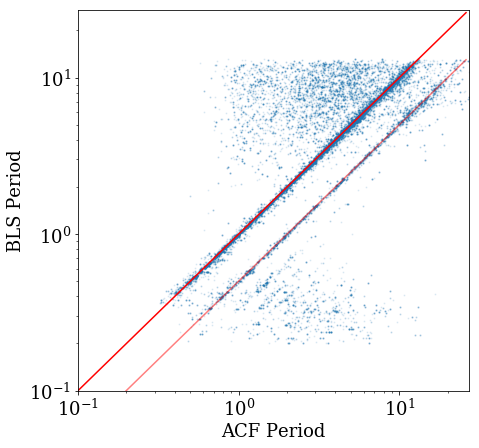

In [107]:
plt.figure(figsize=(7,7))
plt.scatter(gdata['acf_per'].values[ok], gdata['bls_period'].values[ok], alpha=0.1, s=1)
plt.xlabel('ACF Period')
plt.ylabel('BLS Period')
plt.xlim(0.1,27)
plt.ylim(0.1,27)
plt.xscale('log')
plt.yscale('log')
plt.plot([0,26], [0,26], c='r')
plt.plot([0,26], [0,13], c='r', alpha=0.5)

In [109]:
dPer = 0.2
okP = np.where((gdata['acf_per'].values[ok] > 0) & 
               (gdata['acf_per'].values[ok] < 27) & 
               (((gdata['acf_per'].values[ok] / gdata['per'].values[ok] > 1-dPer) & 
                 (gdata['acf_per'].values[ok] / gdata['per'].values[ok] <= 1+dPer)) | 
                ((gdata['acf_per'].values[ok] / gdata['per'].values[ok]/2 > 1-dPer) & 
                 (gdata['acf_per'].values[ok] / gdata['per'].values[ok]/2 <= 1+dPer)) | 
                ((gdata['acf_per'].values[ok] / gdata['bls_period'].values[ok]/2 > 1-dPer) & 
                 (gdata['acf_per'].values[ok] / gdata['bls_period'].values[ok]/2 <= 1+dPer))
               )
              )[0]
okP.shape

(147592,)

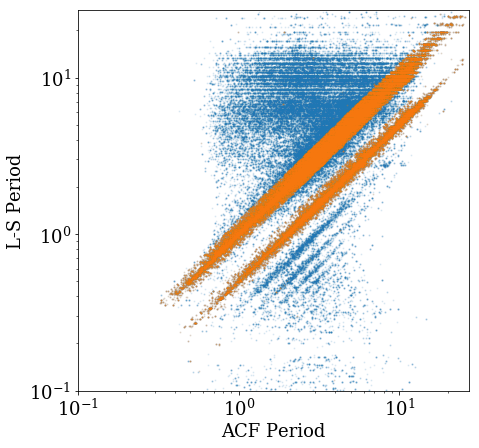

In [110]:
plt.figure(figsize=(7,7))
plt.scatter(gdata['acf_per'].values[ok], gdata['per'].values[ok], alpha=0.1, s=1)
plt.scatter(gdata['acf_per'].values[ok][okP], gdata['per'].values[ok][okP], alpha=0.1, s=1)
plt.xlabel('ACF Period')
plt.ylabel('L-S Period')
plt.xlim(0.1,27)
plt.ylim(0.1,27)
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0, '$G_{BP} - G_{RP}$ (mag)')

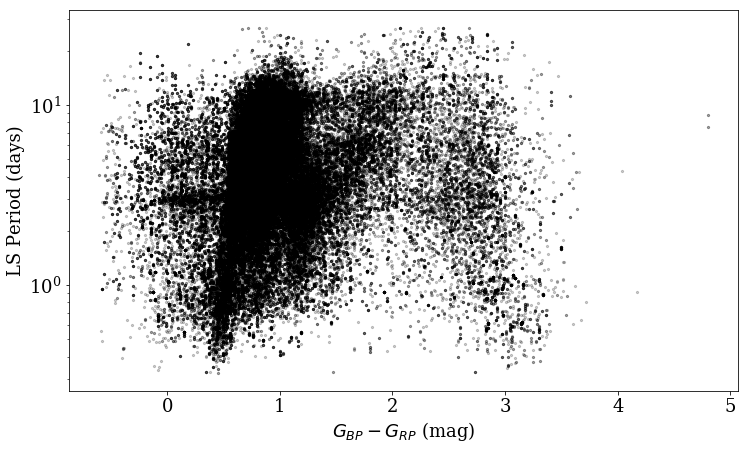

In [111]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok][okP], gdata['acf_per'].values[ok][okP], s=5, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')


/Users/james/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


(15, -5)

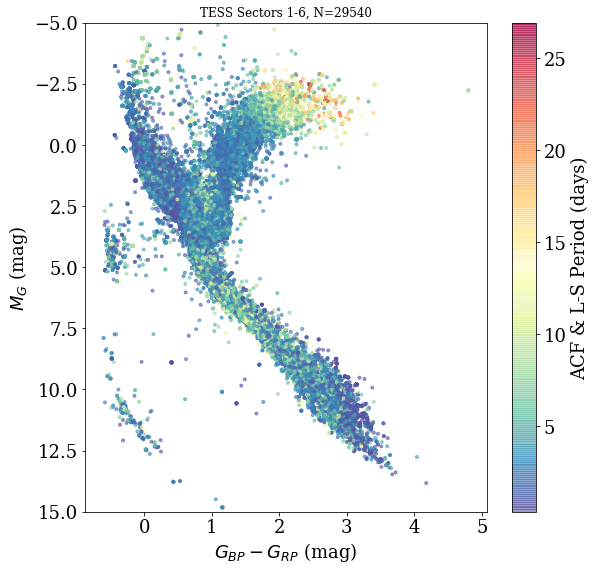

In [112]:

plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'].values[ok][okP], 
            gdata['phot_g_mean_mag'].values[ok][okP] - 5. * np.log10(gdata[u'r_est'].values[ok][okP]) + 5, 
            alpha=0.6, s=9, c=(gdata['acf_per'].values[ok][okP]), 
            cmap=plt.cm.Spectral_r)

cbar = plt.colorbar()
cbar.set_label('ACF & L-S Period (days)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1-6, N='+str(len(gdata['ticid'][ok][okP].unique())), fontsize=12)
plt.ylim(15,-5)

# plt.savefig('cmd_per.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 0, '$M_G$ (mag)')

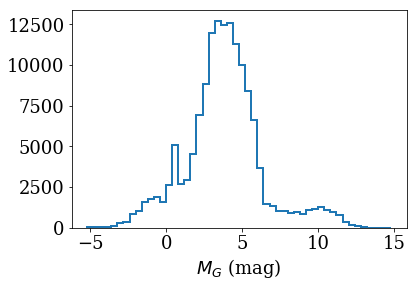

In [113]:
_ = plt.hist(gdata['phot_g_mean_mag'].values[ok][okP] - 5. * np.log10(gdata[u'r_est'].values[ok][okP]) + 5, 
             bins=50, histtype='step', lw=2)
plt.xlabel('$M_G$ (mag)')

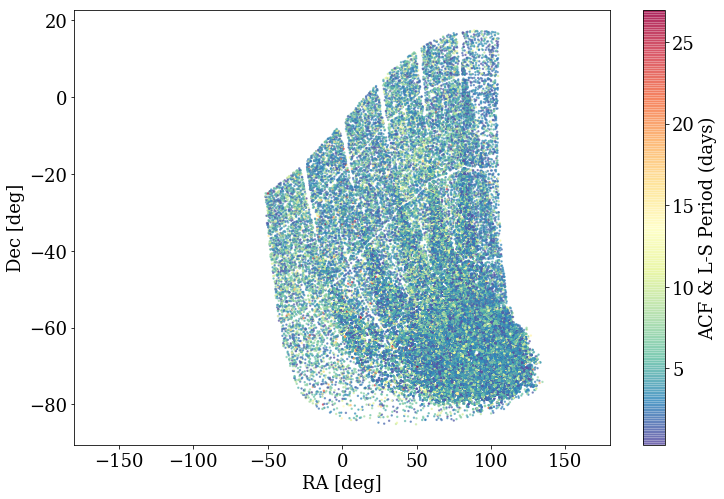

In [114]:
plt.figure(figsize=(12,8))
plt.scatter(gdata['ra'].values[ok][okP], gdata['dec'].values[ok][okP], alpha=0.6, s=2, 
            c=(gdata['acf_per'].values[ok][okP]), 
            cmap=plt.cm.Spectral_r)
plt.scatter(gdata['ra'].values[ok][okP]-360, gdata['dec'].values[ok][okP], alpha=0.6, s=2, 
            c=(gdata['acf_per'].values[ok][okP]), 
            cmap=plt.cm.Spectral_r)



plt.xlim(-180,180)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

cbar = plt.colorbar()
cbar.set_label('ACF & L-S Period (days)')



(15, -5)

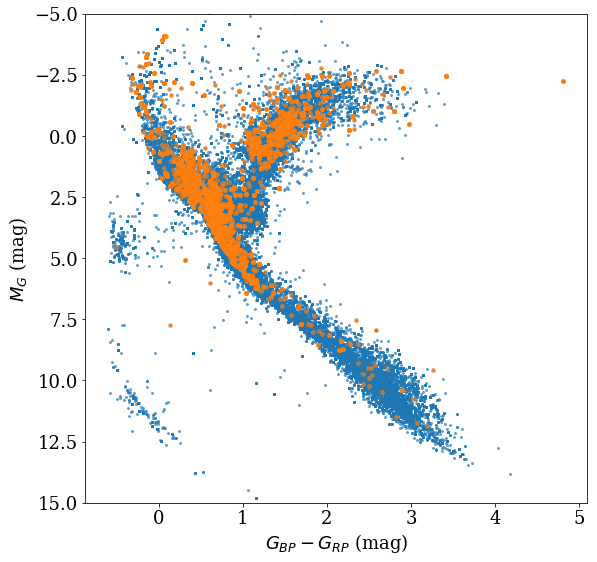

In [119]:
plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'].values[ok][okP], 
            gdata['phot_g_mean_mag'].values[ok][okP] - 5. * np.log10(gdata[u'r_est'].values[ok][okP]) + 5, 
            alpha=0.6, s=4)

ecl = np.where((gdata['ecl_flg'].values[ok][okP] > 0))[0]
plt.scatter(gdata['bp_rp'].values[ok][okP][ecl], 
            gdata['phot_g_mean_mag'].values[ok][okP][ecl] - 5. * np.log10(gdata[u'r_est'].values[ok][okP][ecl]) + 5, 
            alpha=0.6, s=15)

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.title('TESS Sectors 1-6, N='+str(len(gdata['ticid'][ok][okP].unique())), fontsize=12)
plt.ylim(15,-5)

# plt.savefig('cmd_per.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 0, '$G_{BP} - G_{RP}$ (mag)')

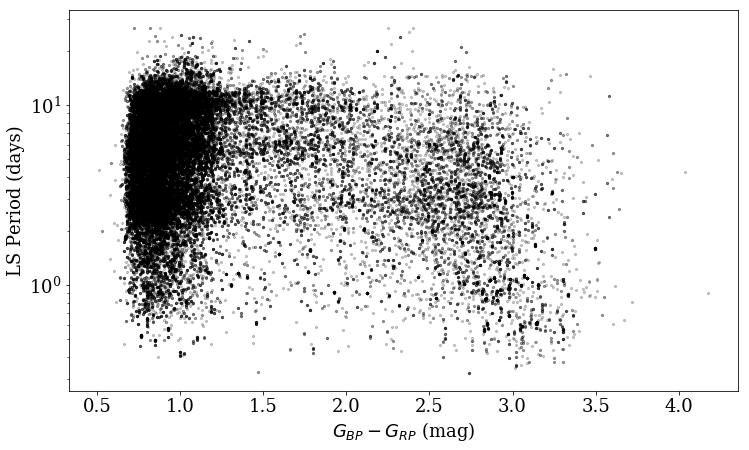

In [123]:
msbad = np.where((gdata['phot_g_mean_mag'].values[ok][okP] - 5. * np.log10(gdata[u'r_est'].values[ok][okP]) + 5 > 4) & 
                 (gdata['phot_g_mean_mag'].values[ok][okP] - 5. * np.log10(gdata[u'r_est'].values[ok][okP]) + 5 < 15) & 
                 (gdata['bp_rp'].values[ok][okP] > 0.5))[0]

plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok][okP][msbad], 
            gdata['acf_per'].values[ok][okP][msbad], s=5, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')

